In [1]:
from Training import DataCreateUpdated as dc
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

rec_path_1 = "OpenBCI-RAW-2021-12-02_19-19-53.txt"
label_path_1 = "JawClench_labels_Ansh_12-02-21-1918.txt"

rec_path_2 = "OpenBCI-RAW-2021-12-02_19-31-12.txt"
label_path_2 = "JawClench_labels_Ansh_12-02-21-1930.txt"

rec_path_3 = "Recordings\Spring_2022\OpenBCISession_2022-02-16_Evan_JawClench_2\OpenBCI-RAW-2022-02-16_19-30-28.txt"
label_path_3 = "Recordings\Spring_2022\Evan_JawClench_1.txt"

#RightFoot_observations = dc.getObservations(RightFoot_path, RightFoot_label_path, 1000, [0,1,2], 'R_FOOT')
#LeftFoot_observations = dc.getObservations(LeftFoot_path, LeftFoot_label_path, 1000, [0,1,2], 'L_FOOT')
jaw_clench_obs_1 = dc.getObservations(rec_path_1, label_path_1, 1000, [0,1,2,3], 'JAW_CLENCH')
jaw_clench_obs_2 = dc.getObservations(rec_path_2, label_path_2, 1000, [0,1,2,3], 'JAW_CLENCH')

y_channels_groups_1, ind_groups_1, t_groups_1, l_groups_1 = jaw_clench_obs_1
y_channels_groups_2, ind_groups_2, t_groups_2, l_groups_2 = jaw_clench_obs_2
#y_channels_groupsLF, ind_groupsLF, t_groupsLF, l_groupsLF = LeftFoot_observations
#y_channels_groupsRF, ind_groupsRF, t_groupsRF, l_groupsRF = RightFoot_observations

(4, 69, 193)


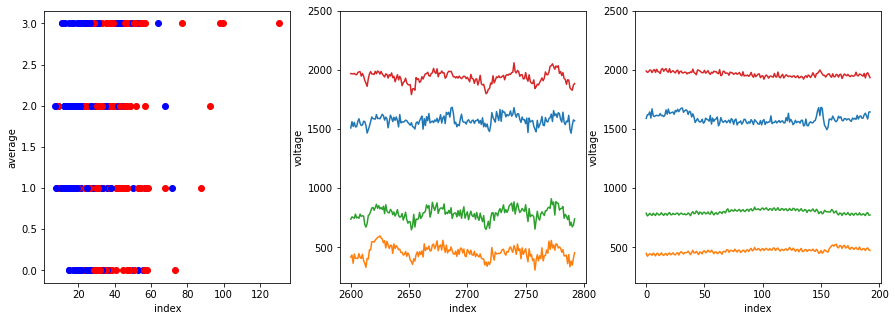

In [5]:
na_ind = 0 #non-action
a_ind = 13 #action

print(y_channels_groups_1.shape)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.xlabel('index')
plt.ylabel('average')

colorgood = ('blue', 'blue', 'blue', 'blue')
colorbad = ('red', 'red', 'red', 'red')
pos = -1
for channel_groups in y_channels_groups_2:
    pos = (pos+1)%4
    for i in range(channel_groups.shape[0]):
        if(l_groups_2[i][0] == 0):
            color = colorbad
        else:
            color = colorgood
        plt.plot(np.mean(np.abs(channel_groups[i] - np.ones_like(channel_groups[i]) * np.mean(channel_groups[i]))), pos, 'o', color = color[pos])

plt.subplot(1,3,2)
plt.xlabel('index')
plt.ylabel('voltage')
plt.ylim(200, 2500)
for channel_groups in y_channels_groups_2:
    plt.plot(ind_groups_2[a_ind], channel_groups[a_ind])


plt.subplot(1,3,3)
plt.xlabel('index')
plt.ylabel('voltage')
plt.ylim(200, 2500)
for channel_groups in y_channels_groups_2:
    plt.plot(ind_groups_2[na_ind], channel_groups[na_ind])

In [3]:
from sklearn import svm
#X = np.concatenate((np.transpose(np.mean(y_channels_groupsLE, axis=2)), np.transpose(np.mean(y_channels_groupsRE, axis=2)), np.transpose(np.mean(y_channels_groupsLF, axis=2)), np.transpose(np.mean(y_channels_groupsRF, axis=2))))
#y = -1*(np.concatenate((l_groupsLE, l_groupsRE, l_groupsLF, l_groupsRF)))
X = np.concatenate((np.transpose(np.mean(y_channels_groups_1, axis=2)), np.transpose(np.mean(y_channels_groups_2, axis=2))))
y = -1*(np.concatenate((l_groups_1, l_groups_2)))


#mean deviation 
processedX1 = np.transpose(np.mean(np.abs(y_channels_groups_1 - np.mean(y_channels_groups_1, axis=2, keepdims=True)), axis=2))
processedX2 = np.transpose(np.mean(np.abs(y_channels_groups_2 - np.mean(y_channels_groups_2, axis=2, keepdims=True)), axis=2))
print(processedX1.shape, processedX2.shape)
ProcessedX = np.concatenate((processedX1, processedX2))

#Using mean and mean deviation
# X = np.concatenate((X, ProcessedX), axis = 1)
#Using just mean deviation
X = ProcessedX

print(X.shape, y.shape)

X_combined = np.concatenate((X, y), axis = 1)
print(X_combined.shape)
#undersampling
# print(X_combined.shape)
# from imblearn.under_sampling import RandomUnderSampler
# under_sampler = RandomUnderSampler(random_state=42)
# X_res, y_res = under_sampler.fit_resample(X_combined, y[:,0])
# print(X_res.shape, y_res.shape)
# X = X_res[:, 0:3]
# y = X_res[:, 3:8]

#oversampling
# from imblearn.over_sampling import RandomOverSampler
# over_sampler = RandomOverSampler(random_state=4)
# X_res, y_res = over_sampler.fit_resample(X_combined, y[:,1])
# y = X_res[:, X.shape[1]:X_combined.shape[1]]
# X = X_res[:, 0:X.shape[1]]

# print("New Shapes", X.shape, y.shape)
# count = 0
# for g in y_res:
#     if g==-1:
#         count+=1
# print(count, y_res.size)
#print(f"Testing target statistics: {y}")

#test-train split
from sklearn.model_selection import train_test_split

X_res, X_test, y_res, y_test = train_test_split(X, y, test_size=0.33, random_state = 4)
X = X_res
y = y_res
# clfLE = svm.SVC(probability=True)
# clfLE.fit(X, y[:,3])
# clfRE = svm.SVC(probability=True)
# clfRE.fit(X, y[:,4])
clfLF = svm.SVC(probability=True)
clfLF.fit(X, y[:,1])
# clfRF = svm.SVC(probability=True)
# clfRF.fit(X, y[:,2])

(69, 4) (69, 4)
(138, 4) (138, 5)
(138, 9)


SVC(probability=True)

In [4]:
correct = 0
total = 0
RecallRate =np.zeros([2, 2])
Precision = np.zeros([2, 2])

# X = np.concatenate((X_test, X))
# y = np.concatenate((y_test, y))

X = X_test
y = y_test

for i in range(X.shape[0]):
    maxVal = 0.5
    maxInd = 0
    #print(clfLE.predict(X[i].reshape(1, -1)))
    if(clfLF.predict_proba(X[i].reshape(1, -1))[0][0]>maxVal):
        maxInd = 1
    # if(clfLE.predict_proba(X[i].reshape(1, -1))[0][0]>maxVal):
    #     maxVal = clfLE.predict_proba(X[i].reshape(1, -1))[0][0]
    #     maxInd = 3
    # if(clfRE.predict_proba(X[i].reshape(1, -1))[0][0]>maxVal):
    #     maxVal = clfRE.predict_proba(X[i].reshape(1, -1))[0][0]
    #     maxInd = 4
    # if(clfLF.predict_proba(X[i].reshape(1, -1))[0][0]>maxVal):
    #     maxVal = clfLF.predict_proba(X[i].reshape(1, -1))[0][0]
    #     maxInd = 1
    # if(clfRF.predict_proba(X[i].reshape(1, -1))[0][0]>maxVal):
    #     maxVal = clfRF.predict_proba(X[i].reshape(1, -1))[0][0]
    #     maxInd = 2
    # resArr = np.zeros(5)
    # resArr[0] = 0.5
    # resArr[1] = 0
    # resArr[2] = 0
    # resArr[3] = clfLE.predict_proba(X[i].reshape(1, -1))[0][0]
    # resArr[4] = clfRE.predict_proba(X[i].reshape(1, -1))[0][0]
#    if(maxInd != 0):
#    print(maxInd, resArr, y[i])
    if(y[i][maxInd]==-1):
        correct+=1
        Precision[maxInd][0]+=1
        RecallRate[maxInd][0]+=1
    for xx in range(2):
        if(y[i][xx]==-1):
            RecallRate[xx][1]+=1
    total+=1
    Precision[maxInd][1]+=1
print(correct/total)
print("Recall")
for row in RecallRate:
    print(row, row[0]/row[1])
print("Precision")
for row in Precision:
    print(row, row[0]/row[1])

0.6956521739130435
Recall
[20. 26.] 0.7692307692307693
[12. 20.] 0.6
Precision
[20. 28.] 0.7142857142857143
[12. 18.] 0.6666666666666666
